<a href="https://colab.research.google.com/github/jan-1995/Quad_Att_PID_Ctrl/blob/main/QUADROTOR_PID_CONTROL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


M14032564 

Name: Haider Jan

Assignment for Modern Control

**IMPORTING ALL LIBRARIES**

In [1]:
from math import cos, sin
import numpy as np
from random import random
import scipy.signal as signal
import scipy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
a= 0.8
b= 5 
c= 1

**DEFINING ALL PARAMETERS AND CONSTANTS**

In [2]:
g = 9.806650  #gravity
m = 1.56  #mass
Jx = 0.114700 #moi wrt x
Jy = 0.057600 #moi wrt y
Jz = 0.171200 #moi wrt z
Ts = 1/10 # sampling time
a= 0.8
b= 5 
c= 1
w1=(2*np.pi)/Ts
w2= w1/2
w3= w1                                       #(w1)/2;
n = 5    
phi_c = 0                                  # psi commanded
theta_c=0

r_c  = 0  

kp_x=7
kd_x=3
kp_y=7
kd_y=3
kp_z=2
kd_z=8 

**DEFINING ALL STATES**

In [3]:
pn = 0 #north
pe = 0 #east
pd = -7 #down

# velocities
u = 0 #wrt north
v = 0 #wrt east
w = 0 #wrt down

# angles
phi = 0   #roll
theta = 0 #pitch
psi = 0   #yaw

# angular rates
p = 0 #wrt roll
q = 0 #wrt pitch
r = 0 #wrt yaw

**Initial values of states**

In [4]:
states = np.array([pn, pe, pd, u, v, w, phi, theta, psi, p, q, r])

**Input Thrust**

In [5]:
F = (m*g*np.cos(theta)*np.cos(phi))

**Controller Gains**

In [6]:
T_phi_max = 2
phi_err = np.pi/5
roll_kp = T_phi_max/phi_err
roll_bo = 1 / Jx
wn_roll = np.sqrt(roll_bo*roll_kp)
zeta_roll = 0.7
roll_kd = (2*zeta_roll*wn_roll/roll_bo)
roll_ki = 0.1

T_theta_max = 2
theta_err = np.pi/6
theta_kp = T_theta_max/theta_err
theta_bo = 1 / Jy
wn_theta = np.sqrt(theta_bo*theta_kp)
zeta_theta = 0.7
theta_kd = (2*zeta_theta*wn_theta/theta_bo)
theta_ki = 0.1

kp_att = 0.5

**DATA COLLECTION FOR TRAJECTORIES AND PLOTS**

In [7]:
pn_data = []
pe_data = []
h_data = []
vn_data = []
ve_data = []
vd_data = []
phi_data = []
theta_data = []
psi_data = []
p_data = []
q_data = []
r_data = []
phi_c_data = []
theta_c_data = []
r_c_data = []

**SIMULATION PARAMETERS**

In [8]:
dt = Ts
Tfinal = 40
Tsteps = Tfinal/dt # number of frames
frames = int(Tsteps)

**ROTATIONAL MATRIX TO CONVERT BODY FRAME TO VEHICLE FRAME WHICH IS THE SAME AS INERTIAL FRAME EXEPT IT IS AT THE COG OF THE QUAD :)**

In [9]:
def rot_mat_bod2veh(phi, theta, psi):


  R_b_v=np.array([[cos(theta)*cos(psi), sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi), cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],
                  [cos(theta)*sin(psi), sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi), cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],
                  [-sin(theta),         sin(phi)*cos(theta),                            cos(phi)*cos(theta)]])
  return R_b_v

**MATRIX TO ORIENT NED TO XYZ**

In [10]:
def axes_ned2yxz():
  
  A_ned = [[0, 1, 0],
           [1, 0, 0],
           [0, 0, -1]]
  return A_ned

**GYRO TO BODY**

In [11]:
def der_ang2rates(phi, theta):
  
  sPh = np.sin(phi)
  cPh = np.cos(phi)
  sT = np.sin(theta)
  cT = np.cos(theta)
  TT = np.tan(theta)
  d_a_r = [[1, sPh*TT, cPh*TT],
           [0, cPh,    -sPh],
           [0, sPh/cT, cPh/cT]]
  return d_a_r

**PID CONTROLLER**

In [12]:
def pid_control(y, y_c, y_dot, kp, kd, ki):

  err = y_c - y
  u = kp*err - kd*y_dot + ki*err*Ts

  return u

**YAW CONTROLLER (INPUT IS YAW RATE AND NOT YAW)**

In [13]:
def yaw_control(r, r_c, kp_att):

  u = kp_att*(r_c-r)
  return u

**MATHEMATICAL MODELING OF THE QUADROTOR**

In [14]:
# Dynamics of the Quadrotor
def quad_dyna(t, y, F, T_phi, T_theta, T_psi):
  pn = y[0]
  pe = y[1]
  pd = y[2]
  u = y[3]
  v = y[4]
  w = y[5]
  phi = y[6]
  theta = y[7]
  psi = y[8]
  p = y[9]
  q = y[10]
  r = y[11]

  # variables for sin, cos and tan functions
  sPh = np.sin(phi)
  cPh = np.cos(phi)
  sT = np.sin(theta)
  cT = np.cos(theta)
  TT = np.tan(theta)
  sPs = np.sin(psi)
  cPs = np.cos(psi)

  lin_v = np.array([u, v, w]).T # linear velocity(u,v,w) array
  ang_v = np.array([p, q, r]).T # angular velocity(p,q,r) array
  R1 = rot_mat_bod2veh(phi, theta, psi) # rotational matrix

  # First equation
  temp0 = np.matmul(R1,lin_v)
  pn_dot = temp0[0]
  pe_dot = temp0[1]
  pd_dot = temp0[2]

  # Second equation
  lin_ang_v = np.array([r*v-q*w, p*w-r*u, q*u-p*v]).T
  #grav_vec = np.array([0, 0, g]).T
  grav_vec = np.array([0, 0, 1*g]).T
  f_mat = np.array([0, 0, -F/m]).T
  
  temp1 = np.cross(ang_v, lin_v) + np.matmul(R1,grav_vec) + f_mat
  u_dot = temp1[0]
  v_dot = temp1[1]
  w_dot = temp1[2]

  # Third Equation
  D = der_ang2rates(phi, theta)
  temp2 = np.matmul(D,ang_v)
  phi_dot = temp2[0]
  theta_dot = temp2[1]
  psi_dot = temp2[2]

  # Forth Equation
  p_dot = (Jy - Jz)/Jx*q*r + (1/Jx)*T_phi
  q_dot = (Jx-Jz)/Jy * p*r + (1/Jy)*T_theta
  r_dot = (Jx-Jy)/Jz * p *q + (1/Jz)*T_psi

  return [pn_dot, pe_dot, pd_dot, u_dot, v_dot, w_dot, phi_dot, theta_dot, psi_dot, p_dot, q_dot, r_dot]





**SOLVING THE STATE SPACE EQUATIONS**

In [15]:
def step(states, dt, i):
  pn = states[0]
  pe = states[1]
  pd = states[2]
  u = states[3]
  v = states[4]
  w = states[5]
  phi = states[6]
  theta = states[7]
  psi = states[8]
  p = states[9]
  q = states[10]
  r = states[11]


  phi_c = np.sin(0/10)
  theta_c = np.cos(0/10)
  r_c = np.sin(0/10)

  phi_c_data.append(phi_c)
  theta_c_data.append(theta_c)
  r_c_data.append(r_c) 

 # F = m * g /( np.cos(phi) * np.cos(theta))
  F = m * g * np.cos(phi) * np.cos(theta)
  T_phi = pid_control(phi, phi_c, p, roll_kp, roll_kd, roll_ki)
  T_theta = pid_control(theta, theta_c, q, theta_kp, theta_kd, theta_ki)
  T_psi = yaw_control(r, r_c, kp_att)
  sol = solve_ivp(lambda t, y: quad_dyna(t, y, F, T_phi, T_theta, T_psi), [0, dt], [pn, pe, pd, u, v, w, phi, theta, psi, p, q, r], t_eval= np.linspace(0, Ts, 10))
  states = sol.y[:,-1].T
  return states

**FUNCTION TO BUILD THE QUADCOPTER**

In [16]:
# function to draw the quad
def build_quad(pn, pe, pd, phi, theta, psi):
  pn = pn
  pe = pe
  pd = pd
  phi = phi
  theta = theta
  psi = psi
  # define width to use as reference to construct the quad 
  w = 1.5

  # defining the coordinates of the end points of the quad rotors
  p1 = np.array([w, 0, 0]).T
  p2 = np.array([-w, 0, 0]).T
  p3 = np.array([0, w, 0]).T
  p4 = np.array([0, -w, 0]).T

  # converting the quadrotor points to interial frame and translating as per ned
  R = rot_mat_bod2veh(phi, theta, psi) # rotational matrix
  pos_ned = np.array([pn, pe, pd]).T #
  p1r = np.matmul(R,p1)+pos_ned
  p2r = np.matmul(R,p2)+pos_ned
  p3r = np.matmul(R,p3)+pos_ned
  p4r = np.matmul(R,p4)+pos_ned

  # changing the orientation of ned wrt yxz
  A = axes_ned2yxz()
  p1ra = np.matmul(A,p1r)
  p2ra = np.matmul(A,p2r)
  p3ra = np.matmul(A,p3r)
  p4ra = np.matmul(A,p4r)

  # Rotor coordinates
  rot_x = [p1ra[0], p2ra[0], p3ra[0], p4ra[0]]
  rot_y = [p1ra[1], p2ra[1], p3ra[1], p4ra[1]]
  rot_z = [p1ra[2], p2ra[2], p3ra[2], p4ra[2]]

  # Arm coordinates
  arm1_x = [p1ra[0], p2ra[0]]
  arm1_y = [p1ra[1], p2ra[1]]
  arm1_z = [p1ra[2], p2ra[2]]

  arm2_x = [p3ra[0], p4ra[0]]
  arm2_y = [p3ra[1], p4ra[1]]
  arm2_z = [p3ra[2], p4ra[2]]

  # defining the coordinates of the payload
  v1 = np.array([-w/3,-w/3,w/2]).T
  v2 = np.array([-w/3,-w/3,0]).T
  v3 = np.array([w/3,-w/3,0]).T
  v4 = np.array([w/3,-w/3,w/2]).T
  v5 = np.array([w/3,w/3,w/2]).T
  v6 = np.array([w/3,w/3,0]).T
  v7 = np.array([-w/3,w/3,0]).T
  v8 = np.array([-w/3,w/3,w/2]).T

  # converting the payload points to interial frame and translating as per ned
  v1r = np.matmul(R,v1)+pos_ned
  v2r = np.matmul(R,v2)+pos_ned
  v3r = np.matmul(R,v3)+pos_ned
  v4r = np.matmul(R,v4)+pos_ned
  v5r = np.matmul(R,v5)+pos_ned
  v6r = np.matmul(R,v6)+pos_ned
  v7r = np.matmul(R,v7)+pos_ned
  v8r = np.matmul(R,v8)+pos_ned

  # changing the orientation of ned wrt yxz
  v1ra = np.matmul(A,v1r)
  v2ra = np.matmul(A,v2r)
  v3ra = np.matmul(A,v3r)
  v4ra = np.matmul(A,v4r)
  v5ra = np.matmul(A,v5r)
  v6ra = np.matmul(A,v6r)
  v7ra = np.matmul(A,v7r)
  v8ra = np.matmul(A,v8r)

  # defining the faces of the payload
  f1_x=[v1ra[0], v2ra[0], v3ra[0], v4ra[0], v1ra[0]]
  f1_y=[v1ra[1], v2ra[1], v3ra[1], v4ra[1], v1ra[1]]
  f1_z=[v1ra[2], v2ra[2], v3ra[2], v4ra[2], v1ra[2]]
  f2_x=[v5ra[0], v6ra[0], v7ra[0], v8ra[0], v5ra[0]]
  f2_y=[v5ra[1], v6ra[1], v7ra[1], v8ra[1], v5ra[1]]
  f2_z=[v5ra[2], v6ra[2], v7ra[2], v8ra[2], v5ra[2]]
  f3_x=[v4ra[0], v5ra[0], v6ra[0], v3ra[0], v4ra[0]]
  f3_y=[v4ra[1], v5ra[1], v6ra[1], v3ra[1], v4ra[1]]
  f3_z=[v4ra[2], v5ra[2], v6ra[2], v3ra[2], v4ra[2]]
  f4_x=[v1ra[0], v8ra[0], v7ra[0], v2ra[0], v1ra[0]]
  f4_y=[v1ra[1], v8ra[1], v7ra[1], v2ra[1], v1ra[1]]
  f4_z=[v1ra[2], v8ra[2], v7ra[2], v2ra[2], v1ra[2]]

  return rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z
  


**Initial Plot**

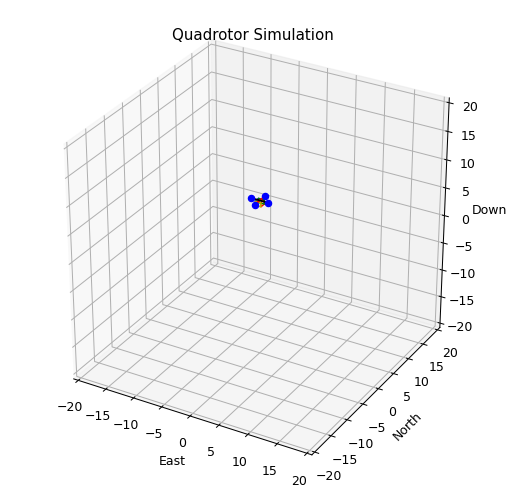

In [17]:
#Intial Plot
fig = plt.figure(figsize=(7,7), dpi=90)
ax = fig.add_subplot(1, 1, 1,projection='3d')
ax.set_xlim(( -20, 20))            
ax.set_ylim((-20, 20))
ax.set_zlim((-20, 20))
ax.set_xlabel('East')
ax.set_ylabel('North')
ax.set_zlabel('Down')
ax.set_title('Quadrotor Simulation')

rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z = build_quad(pn, pe, pd, phi, theta, psi)

# Collecting data for trajectories and plots
pn_data.append(states[0])
pe_data.append(states[1])
h_data.append(-states[2])
vn_data.append(states[3])
ve_data.append(states[4])
vd_data.append(states[5])
phi_data.append(states[6])
theta_data.append(states[7])
psi_data.append(states[8])
p_data.append(states[9])
q_data.append(states[10])
r_data.append(states[11])
# payload
face1, = ax.plot(f1_x, f1_y, f1_z, 'b', lw=1.1)
face2, = ax.plot(f2_x, f2_y, f2_z, 'r', lw=1.1)
face3, = ax.plot(f3_x, f3_y, f3_z, 'g', lw=1.1)
face4, = ax.plot(f4_x, f4_y, f4_z, 'y', lw=1.1)

# arms and rotors
arm1, = ax.plot(arm1_x, arm1_y, arm1_z, 'r-', lw=1.5)
arm2, = ax.plot(arm2_x, arm2_y, arm2_z, 'k-', lw=1.5)
rotor, = ax.plot(rot_x, rot_y, rot_z, 'bo', ms = 5)

# trajectory
traj, = ax.plot(pe_data, pn_data, h_data, 'g:', lw=1)


**FUCNTION FOR UPDATING THE POINTS OF THE PAYLOAD**

In [18]:
def drawframe(i):
  global states
  states = step(states, dt,i)
  pn = states[0]
  pe = states[1]
  pd = states[2]
  u = states[3]
  v = states[4]
  w = states[5]
  phi = states[6]
  theta = states[7]
  psi = states[8]
  p = states[9]
  q = states[10]
  r = states[11]

  
  rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z = build_quad(pn, pe, pd, phi, theta, psi)

  pn_data.append(states[0])
  pe_data.append(states[1])
  h_data.append(-states[2])
  vn_data.append(states[3])
  ve_data.append(states[4])
  vd_data.append(states[5])
  phi_data.append(states[6])
  theta_data.append(states[7])
  psi_data.append(states[8])
  p_data.append(states[9])
  q_data.append(states[10])
  r_data.append(states[11])

  face1.set_data(f1_x, f1_y)
  face1.set_3d_properties(f1_z)
  face2.set_data(f2_x, f2_y)
  face2.set_3d_properties(f2_z)
  face3.set_data(f3_x, f3_y)
  face3.set_3d_properties(f3_z)
  face4.set_data(f4_x, f4_y)
  face4.set_3d_properties(f3_z)

  arm1.set_data(arm1_x, arm1_y)
  arm1.set_3d_properties(arm1_z)
  arm2.set_data(arm2_x, arm2_y)
  arm2.set_3d_properties(arm2_z)
  rotor.set_data(rot_x, rot_y)
  rotor.set_3d_properties(rot_z)

  traj.set_data(pe_data, pn_data)
  traj.set_3d_properties(h_data)

  return face1, face2, face3, face4, arm1, arm2, rotor, traj

**Function to Collect the state data to facilitate plots**

In [19]:
def state_plot(i):
  global states
  states = step(states, dt, i)
  pn = states[0]
  pe = states[1]
  pd = states[2]
  u = states[3]
  v = states[4]
  w = states[5]
  phi = states[6]
  theta = states[7]
  psi = states[8]
  p = states[9]
  q = states[10]
  r = states[11]

  pn_data.append(states[0])
  pe_data.append(states[1])
  h_data.append(-states[2])
  vn_data.append(states[3])
  ve_data.append(states[4])
  vd_data.append(states[5])
  phi_data.append(states[6])
  theta_data.append(states[7])
  psi_data.append(states[8])
  p_data.append(states[9])
  q_data.append(states[10])
  r_data.append(states[11])

  return pn_data, pe_data, h_data, vn_data, ve_data, vd_data, phi_data, theta_data, psi_data, p_data, q_data, r_data

**Creating the Simulation**

In [20]:
ax.set_xlabel('East(x)')
ax.set_ylabel('North(y)')
ax.set_zlabel('Down(z)')
ax.set_title('Quadrotor Simulation')
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=frames, interval=40, blit=True)

In [21]:
HTML(anim.to_html5_video())

**FIGURE TO PLOT ALL THE STATES AGAINST THE TIE STEP**

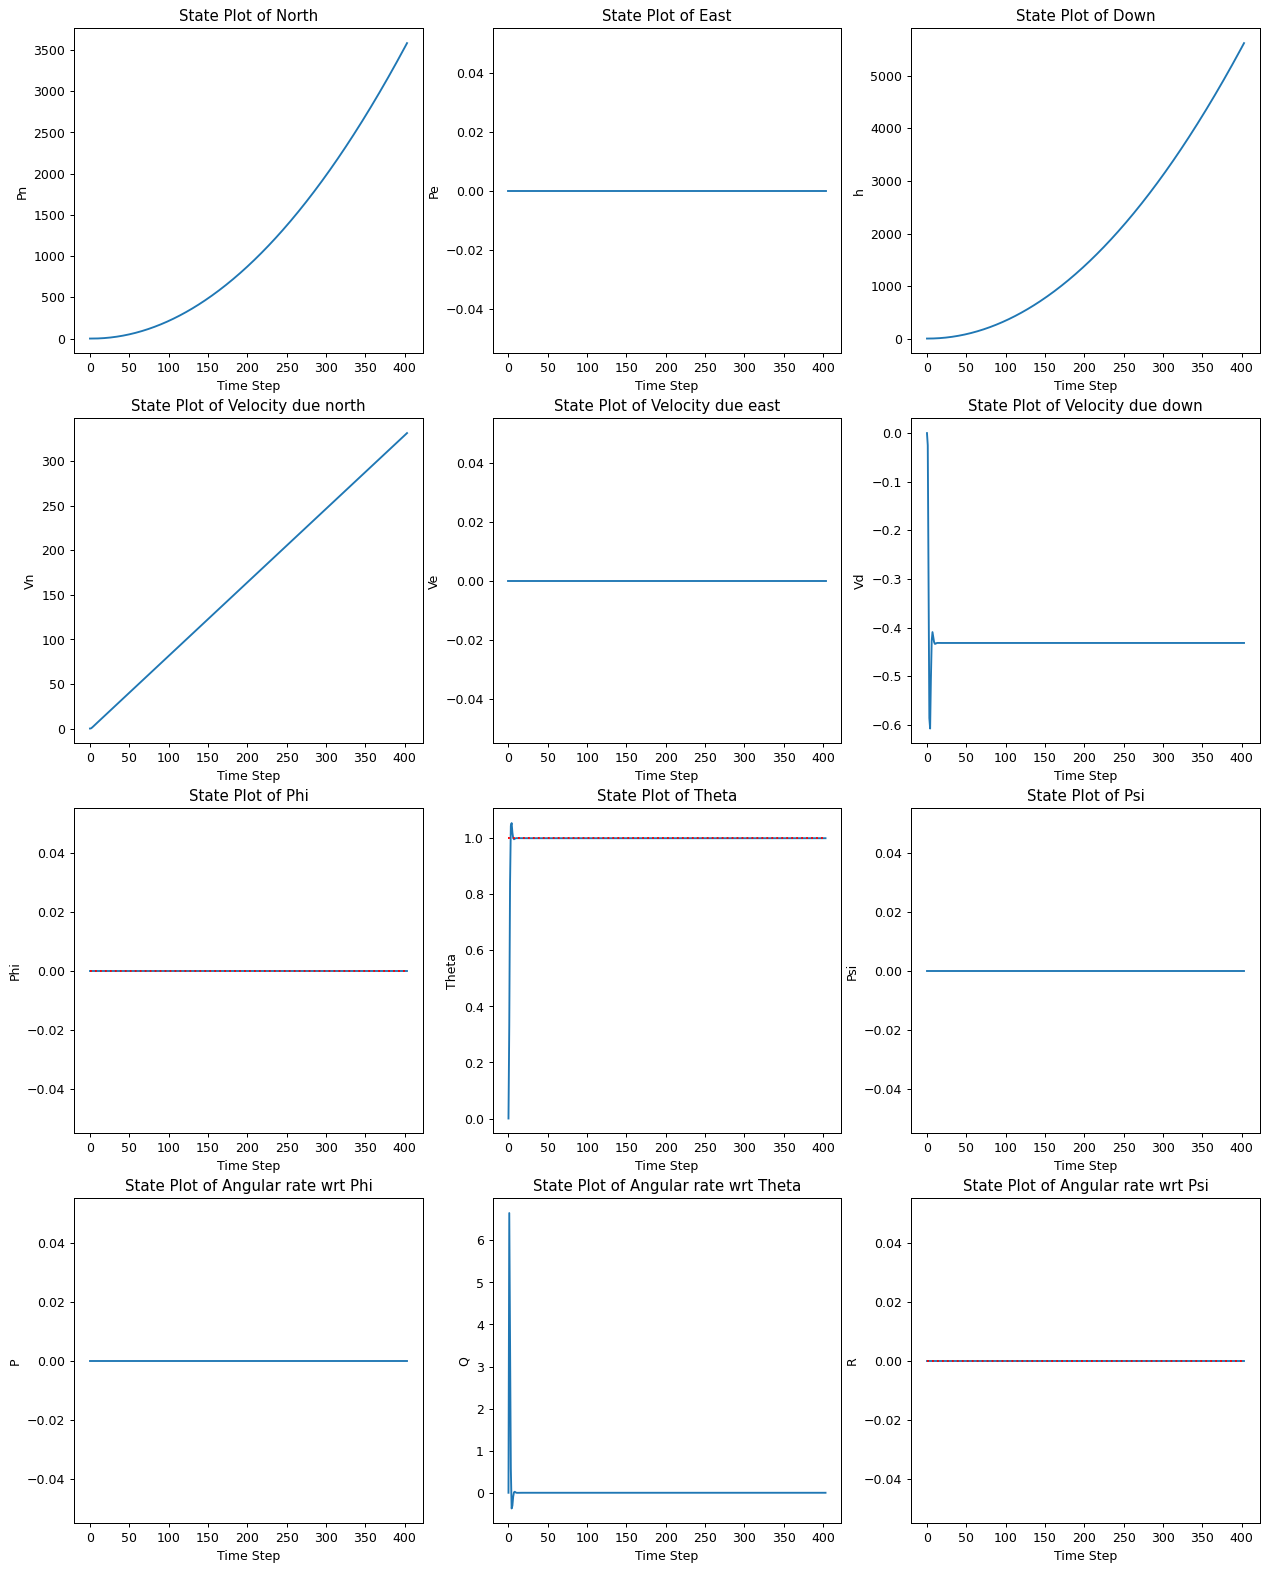

In [22]:
# Figure to plot the states against time step
pn_data1, pe_data1, h_data1, vn_data1, ve_data1, vd_data1, phi_data1, theta_data1, psi_data1, p_data1, q_data1, r_data1 = state_plot(100)

fig1 = plt.figure(figsize=(17,22), dpi=90)
ax1 = fig1.add_subplot(4, 3, 1)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Pn')
ax1.set_title('State Plot of North')
pn1 = ax1.plot(range(len(pn_data1)),pn_data1)
ax2 = fig1.add_subplot(4, 3, 2)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Pe')
ax2.set_title('State Plot of East')
pe1 = ax2.plot(range(len(pe_data1)),pe_data1)
ax3 = fig1.add_subplot(4, 3, 3)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('h')
ax3.set_title('State Plot of Down')
h1 = ax3.plot(range(len(h_data1)),h_data1)
ax4 = fig1.add_subplot(4, 3, 4)
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Vn')
ax4.set_title('State Plot of Velocity due north')
vn1 = ax4.plot(range(len(vn_data1)),vn_data1)
ax5 = fig1.add_subplot(4, 3, 5)
ax5.set_xlabel('Time Step')
ax5.set_ylabel('Ve')
ax5.set_title('State Plot of Velocity due east')
ve1 = ax5.plot(range(len(ve_data1)),ve_data1)
ax6 = fig1.add_subplot(4, 3, 6)
ax6.set_xlabel('Time Step')
ax6.set_ylabel('Vd')
ax6.set_title('State Plot of Velocity due down')
vd1 = ax6.plot(range(len(vd_data1)),vd_data1)
ax7 = fig1.add_subplot(4, 3, 7)
ax7.set_xlabel('Time Step')
ax7.set_ylabel('Phi')
ax7.set_title('State Plot of Phi')
phi1 = ax7.plot(range(len(phi_data1)),phi_data1)
phi_c1 = ax7.plot(range(len(phi_c_data)),phi_c_data,'r:')
ax8 = fig1.add_subplot(4, 3, 8)
ax8.set_xlabel('Time Step')
ax8.set_ylabel('Theta')
ax8.set_title('State Plot of Theta')
theta1 = ax8.plot(range(len(theta_data1)),theta_data1)
theta_c1 = ax8.plot(range(len(theta_c_data)),theta_c_data,'r:')
ax9 = fig1.add_subplot(4, 3, 9)
ax9.set_xlabel('Time Step')
ax9.set_ylabel('Psi')
ax9.set_title('State Plot of Psi')
psi1 = ax9.plot(range(len(psi_data1)),psi_data1)
ax10 = fig1.add_subplot(4, 3, 10)
ax10.set_xlabel('Time Step')
ax10.set_ylabel('P')
ax10.set_title('State Plot of Angular rate wrt Phi')
p1 = ax10.plot(range(len(p_data1)),p_data1)
ax11 = fig1.add_subplot(4, 3, 11)
ax11.set_xlabel('Time Step')
ax11.set_ylabel('Q')
ax11.set_title('State Plot of Angular rate wrt Theta')
q1 = ax11.plot(range(len(q_data1)),q_data1)
ax12 = fig1.add_subplot(4, 3, 12)
ax12.set_xlabel('Time Step')
ax12.set_ylabel('R')
ax12.set_title('State Plot of Angular rate wrt Psi')
r1 = ax12.plot(range(len(r_data1)),r_data1)
r_c1 = ax12.plot(range(len(r_c_data)),r_c_data,'r:')